# Домашнее задание № 9

### Задание 1 (10 баллов).
Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/transfer_learning_hg/Fine_tunining_pretrained_LMs_torch.ipynb

На датасете lenta_sample.ru  дообучите две модели - modernbert-base (из семинара) и rumodernbert-base (https://huggingface.co/deepvk/RuModernBERT-base). Оцените разницу в качестве сравнив поклассовые метрики (classification_report)

Для обоих моделей качество должно быть >0.10 по f-мере (прогоните несколько экспериментов если у вас получаются нули, изменяя параметры).
Также для обоих моделей попробуйте дообучать модель и целиком и дообучать только последний слой.
Для RuModernBERT дополнительно сравните модель, которая использует первый вектор (cls токен, как в семинаре), так и усредненный вектор по всем hidden_state, который выдает bert.




In [1]:
import numpy as np
import pandas as pd
from string import punctuation

from transformers import AutoModel
from transformers import AutoTokenizer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
data = pd.read_csv('lenta_sample.csv')
data.head(2)

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2010/12/16/passports/,Московская милиция ужесточила паспортный режим,В Москве после серии массовых беспорядков на н...,Россия,Все,2010/12/16
1,https://lenta.ru/news/2014/05/19/student/,Московского студента ограбили на 6 миллионов р...,Неизвестные вынесли из квартиры московского ст...,Россия,NaN,2014/05/19


In [7]:
data['topic'].value_counts()

,count
topic,
Из жизни,55
Наука и техника,54
Бывший СССР,54
Культура,53
Ценности,45
Дом,45
Бизнес,44
Интернет и СМИ,44
Силовые структуры,40


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
def train(model, iterator, optimizer, criterion, print_every=1000):

    epoch_loss = []
    epoch_f1 = []

    model.train()

    for i, (texts, ys) in enumerate(iterator):

        optimizer.zero_grad()
        predictions = model(texts.to(device)).squeeze()
        loss = criterion(predictions, ys.to(device))



        loss.backward()
        optimizer.step()
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()

        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))

        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')

    return np.mean(epoch_f1)

In [10]:
def evaluate(model, iterator, criterion):

    epoch_loss = []
    epoch_f1 = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:

            predictions = model(texts.to(device)).squeeze()
            loss = criterion(predictions, ys.to(device))
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()


            epoch_loss.append(loss.item())
            epoch_f1.append(f1_score(y_true, preds, average="micro"))

    return np.mean(epoch_f1)

In [11]:
def predict(model, iterator):

    preds = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:
            predictions = model(texts.to(device)).squeeze()
            ys = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            preds.extend(ys)

    return preds

In [12]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, MAX_LEN, texts, targets):

        self.tokenizer = tokenizer
        self.texts = [torch.LongTensor(tokenizer.encode(t)[:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True,
                                                     padding_value=self.tokenizer.pad_token_id)

        self.MAX_LEN = MAX_LEN
        self.length = len(texts)

        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y

    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [13]:
class CLF(nn.Module):

    def __init__(self, pretrained_model, num_classes):
        super().__init__()
        self.tokenizer = tokenizer
        self.pretrained_model = pretrained_model
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(768, num_classes)
        self.act = nn.LogSoftmax(1)

    def forward(self, texts):
        mask = (texts != tokenizer.pad_token_id).long()

        hidden = self.pretrained_model(texts, attention_mask=mask)[0]

        dense_outputs=self.fc(self.drop(hidden[:,0] ))
        outputs=self.act(dense_outputs)

        return outputs

In [14]:
class CLF_HS(nn.Module):

    def __init__(self, pretrained_model, num_classes):
        super().__init__()
        self.tokenizer = tokenizer
        self.pretrained_model = pretrained_model
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(768, num_classes)
        self.act = nn.LogSoftmax(1)

    def forward(self, texts):
        mask = (texts != self.tokenizer.pad_token_id).long()

        hidden = self.pretrained_model(texts, attention_mask=mask, output_hidden_states=True).hidden_states
        hidden_avg = torch.stack([torch.mean(hs.float(), dim=1) for hs in hidden[1:]]).mean(dim=0)

        dense_outputs = self.fc(self.drop(hidden_avg))
        outputs = self.act(dense_outputs)

        return outputs

In [15]:
MAX_LEN = 512

In [16]:
texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

In [17]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

### ModernBERT без заморозки

In [ ]:
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

In [ ]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [ ]:
model = CLF(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


In [ ]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.09583333333333333
1
Eval -  0.09583333333333333
2
Eval -  0.125
3
Eval -  0.12916666666666665
4
Eval -  0.12708333333333333
5
Eval -  0.12708333333333333
6
Eval -  0.1625
7
Eval -  0.13125
8
Eval -  0.22291666666666665
9
Eval -  0.1625
10
Eval -  0.19375
11
Eval -  0.12916666666666665
12
Eval -  0.06458333333333333
13
Eval -  0.19375
14
Eval -  0.12916666666666665
15
Eval -  0.22708333333333333
16
Eval -  0.16041666666666665
17
Eval -  0.15625
18
Eval -  0.225
19
Eval -  0.19583333333333333
20
Eval -  0.19166666666666665
21
Eval -  0.16041666666666665
22
Eval -  0.12916666666666665
23
Eval -  0.16041666666666665
24
Eval -  0.06458333333333333
25
Eval -  0.12916666666666665
26
Eval -  0.15833333333333333
27
Eval -  0.12708333333333333
28
Eval -  0.1625
29
Eval -  0.22916666666666666


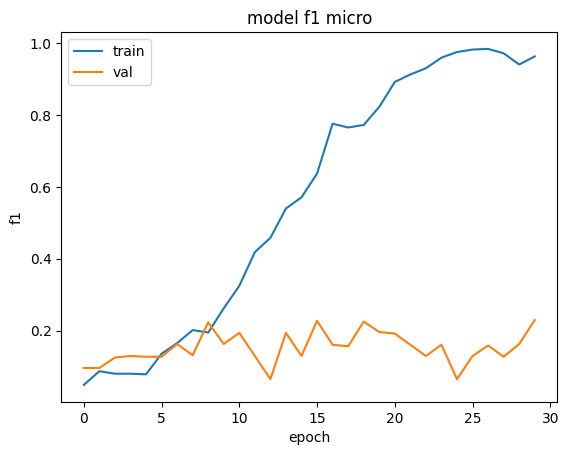

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [ ]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         1
           2       1.00      0.50      0.67         2
           4       0.50      0.50      0.50         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         3
           9       0.50      0.50      0.50         2
          11       0.50      0.50      0.50         2
          12       1.00      0.33      0.50         3
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         1
          15       0.12      0.25      0.17         4
          16       0.17      0.25      0.20         4

    accuracy                           0.23        31
   macro avg       0.29      0.22      0.23        31
weighted avg       0.30      0.23      0.24        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### ModernBERT c заморозкой

In [ ]:
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

for param in model_bert.parameters():
    param.requires_grad = False

In [ ]:
model = CLF(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
0.0000877222


In [ ]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.16129032258064516
1
Eval -  0.16129032258064516
2
Eval -  0.1935483870967742
3
Eval -  0.1935483870967742
4
Eval -  0.16129032258064516
5
Eval -  0.0967741935483871
6
Eval -  0.12903225806451613
7
Eval -  0.1935483870967742
8
Eval -  0.1935483870967742
9
Eval -  0.16129032258064516
10
Eval -  0.16129032258064516
11
Eval -  0.16129032258064516
12
Eval -  0.1935483870967742
13
Eval -  0.1935483870967742
14
Eval -  0.16129032258064516
15
Eval -  0.12903225806451613
16
Eval -  0.1935483870967742
17
Eval -  0.16129032258064516
18
Eval -  0.1935483870967742
19
Eval -  0.16129032258064516
20
Eval -  0.16129032258064516
21
Eval -  0.1935483870967742
22
Eval -  0.16129032258064516
23
Eval -  0.1935483870967742
24
Eval -  0.1935483870967742
25
Eval -  0.16129032258064516
26
Eval -  0.22580645161290322
27
Eval -  0.1935483870967742
28
Eval -  0.22580645161290322
29
Eval -  0.1935483870967742


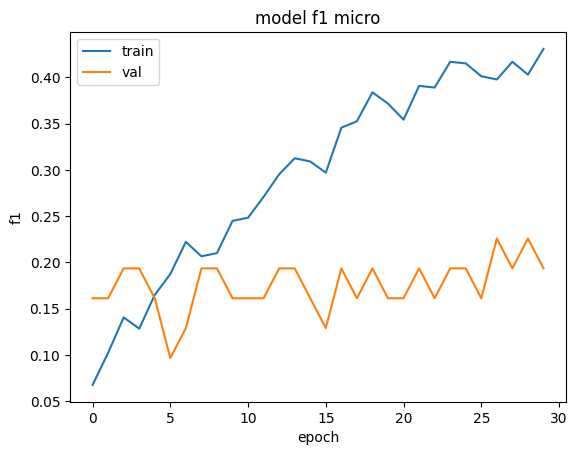

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [ ]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.50      0.50      0.50         2
           5       0.00      0.00      0.00         2
           6       0.25      0.33      0.29         3
           9       0.25      0.50      0.33         2
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4
          16       0.25      0.50      0.33         4

    accuracy                           0.19        31
   macro avg       0.12      0.15      0.13        31
weighted avg       0.15      0.19      0.16        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

### RuModernBERT без заморозки

In [ ]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.75M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [ ]:
model = CLF(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


In [ ]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.0
1
Eval -  0.0967741935483871
2
Eval -  0.12903225806451613
3
Eval -  0.12903225806451613
4
Eval -  0.0967741935483871
5
Eval -  0.1935483870967742
6
Eval -  0.16129032258064516
7
Eval -  0.3225806451612903
8
Eval -  0.16129032258064516
9
Eval -  0.06451612903225806
10
Eval -  0.2903225806451613
11
Eval -  0.16129032258064516
12
Eval -  0.1935483870967742
13
Eval -  0.16129032258064516
14
Eval -  0.12903225806451613
15
Eval -  0.06451612903225806
16
Eval -  0.1935483870967742
17
Eval -  0.0967741935483871
18
Eval -  0.1935483870967742
19
Eval -  0.16129032258064516
20
Eval -  0.16129032258064516
21
Eval -  0.1935483870967742
22
Eval -  0.1935483870967742
23
Eval -  0.1935483870967742
24
Eval -  0.0967741935483871
25
Eval -  0.16129032258064516
26
Eval -  0.03225806451612903
27
Eval -  0.22580645161290322
28
Eval -  0.12903225806451613
29
Eval -  0.16129032258064516


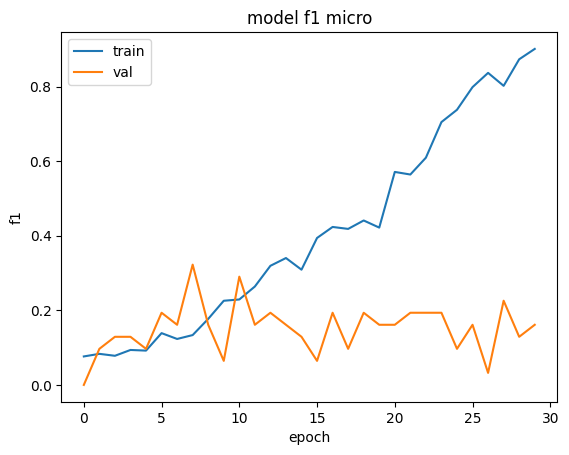

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [ ]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         2
          11       0.33      0.50      0.40         2
          12       0.50      0.33      0.40         3
          13       1.00      0.50      0.67         2
          14       0.00      0.00      0.00         1
          15       0.29      0.50      0.36         4
          16       0.00      0.00      0.00         4

    accuracy                           0.16        31
   macro avg       0.15      0.13      0.13        31
weighted avg       0.17      0.16      0.15        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

### RuModernBERT с заморозкой

In [62]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

for param in model_bert.parameters():
    param.requires_grad = False

In [63]:
model = CLF(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [64]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
0.0000877222


In [65]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.03125
1
Eval -  0.03333333333333333
2
Eval -  0.06666666666666667
3
Eval -  0.06458333333333333
4
Eval -  0.03333333333333333
5
Eval -  0.06666666666666667
6
Eval -  0.0625
7
Eval -  0.03125
8
Eval -  0.03125
9
Eval -  0.06458333333333333


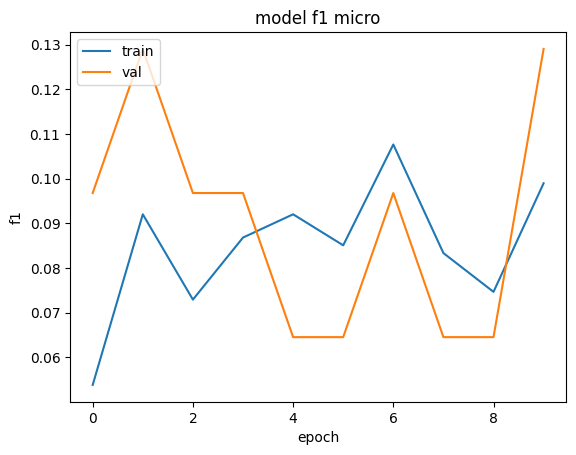

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [ ]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.40      0.67      0.50         3
           9       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          13       0.08      1.00      0.14         2
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         4

    accuracy                           0.13        31
   macro avg       0.04      0.13      0.05        31
weighted avg       0.04      0.13      0.06        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### RuModernBERT hidden states

Без заморозки, так как результаты были лучше.

In [67]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

In [68]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [69]:
model = CLF_HS(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [70]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


In [71]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.2583333333333333
1
Eval -  0.4875
2
Eval -  0.6166666666666667
3
Eval -  0.7125
4
Eval -  0.7041666666666666
5
Eval -  0.65
6
Eval -  0.74375
7
Eval -  0.7416666666666667
8
Eval -  0.75
9
Eval -  0.6833333333333333
10
Eval -  0.74375
11
Eval -  0.8104166666666667
12
Eval -  0.74375
13
Eval -  0.775
14
Eval -  0.7416666666666667
15
Eval -  0.7145833333333333
16
Eval -  0.70625
17
Eval -  0.6458333333333333
18
Eval -  0.7104166666666667
19
Eval -  0.7104166666666667
20
Eval -  0.7145833333333333
21
Eval -  0.7083333333333333
22
Eval -  0.7104166666666667
23
Eval -  0.7104166666666667
24
Eval -  0.7083333333333333
25
Eval -  0.7104166666666667
26
Eval -  0.7104166666666667
27
Eval -  0.7125
28
Eval -  0.7125
29
Eval -  0.7104166666666667


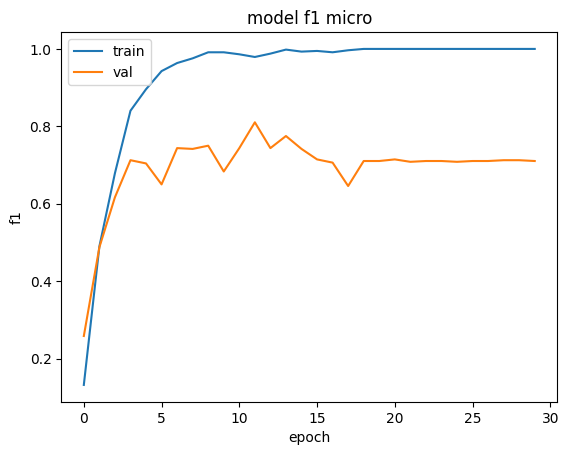

In [72]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [73]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [74]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.40      0.67      0.50         3
           2       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       0.50      1.00      0.67         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         1
          10       0.80      0.67      0.73         6
          11       0.75      1.00      0.86         3
          13       1.00      1.00      1.00         1
          14       1.00      0.50      0.67         2
          15       1.00      0.33      0.50         3
          16       1.00      0.67      0.80         3

    accuracy                           0.71        31
   macro avg       0.72      0.72      0.68        31
weighted avg       0.78   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


RuModernBERT показывает качество хуже, особенно с заморозкой, как бы я не пыталась выбить качество больше 0.1, у меня не получилось... ModernBERT показал себя примерно одинаково, но без заморозки немного лучше. Лучше всего получилась RuModernBERT с hidden states, она показала результаты намного лучше.